# Best Practices - PyTorch YOLOv7 on PASCAL VOC

## Optimizing YOLOv7 with NetsPresso Model Compressor
By following this notebook, the user can get YOLOv7 which has 1.42x low latency, 1.35x fewer parameters only with 1.2% mAP(0.5) drop by using NetsPresso Model Compressor.


This notebook contains the following 5 parts:
  1. [Model Compression with NetsPresso Model Compressor](#1.-Model-Compression-with-NetsPresso-Model-Compressor)
  2. [Fine-Tuning the Compressed Model](#2.-Fine-tuning-the-Compressed-Model)
  3. [Compression Results](#3.-Compression-Results)
  4. [Appendix 1. Transfer Learning on PASCAL VOC](#Appendix-1.-Transfer-Learning-on-PASCAL-VOC)
  5. [Appendix 2. Description of The Modifications](#Appendix-2.-Description-of-The-Modifications)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai).


<div align="center">

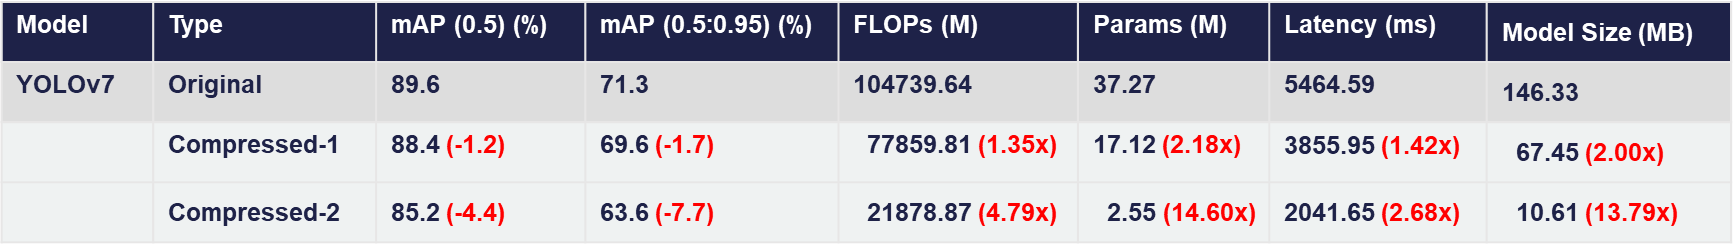
</div>
<div align='center'>
Fig. 1 Compression results of the YOLOv7. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex). We set the model's data type to FP32, and an inference engine to ONNX Runtime to measure the latency. Note that we measured information from the models after reparameterization.
</div>


<a name="1.-Model-Compression-with-NetsPresso-Model-Compressor"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Setting up your environment


Cloning the YOLOV7 code ([link](https://github.com/WongKinYiu/yolov7))

In [ ]:
! git clone  https://github.com/WongKinYiu/yolov7.git

Please make sure your current directory is `yolov7`.

In [ ]:
import os
os.chdir('yolov7')

! pwd

Installing the following packages:

In [ ]:
! pip install -r requirements.txt
! pip install onnx
! pip install onnxruntime
! pip install thop
! pip install torchinfo
! pip install torchsummary
! apt-get install -y libgl1-mesa-glx
# You MUST install the compatible torch version with your cuda version. Here, we set PyTorch 1.13.1 with CUDA 11.6 as default. (Support: PyTorch version >= 1.10) 
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
! pip install numpy==1.22.0

### Preparing the pretrained model

You can get the PASCAL VOC pretrained YOLOv7 (GraphModule format) `yolov7_voc.pt` by running the following code block. The model will be downloaded in the directory `yolov7`.
* Or, you can train YOLOv7 on PASCAL VOC in [Appendix 1](#Appendix-1.-Transfer-Learning-on-PASCAL-VOC).

In [ ]:
# Download PASCAL VOC pretrained YOLOv7 (GraphModule format)
! wget https://netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com/model_zoo/torch/pascal_voc/pretrained/yolov7_voc.pt

### **YOLOv7 compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up for NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the original YOLOv7 `yolov7_voc.pt`. The model format should be `GraphModule (torch.fx.GraphModule)`.
3. To reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#2.-Fine-tuning-the-Compressed-Model): 
    * For Compressed-1,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.3`
    * For Compressed-2,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.6`
        * Fine-tuning the model
        * `Tucker Decomposition` &rarr; `Recommendation(VBMF) calibration ratio: 0.2` (Please select compression mode as `Advanced Compression` to use `Tucker Decomposition` method and dismiss rbr_dense blocks [`102_rbr_dense_0`, `103_rbr_dense_0`, `104_rbr_dense_0`] to reparameterize the blocks.)
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

<div align='center'>
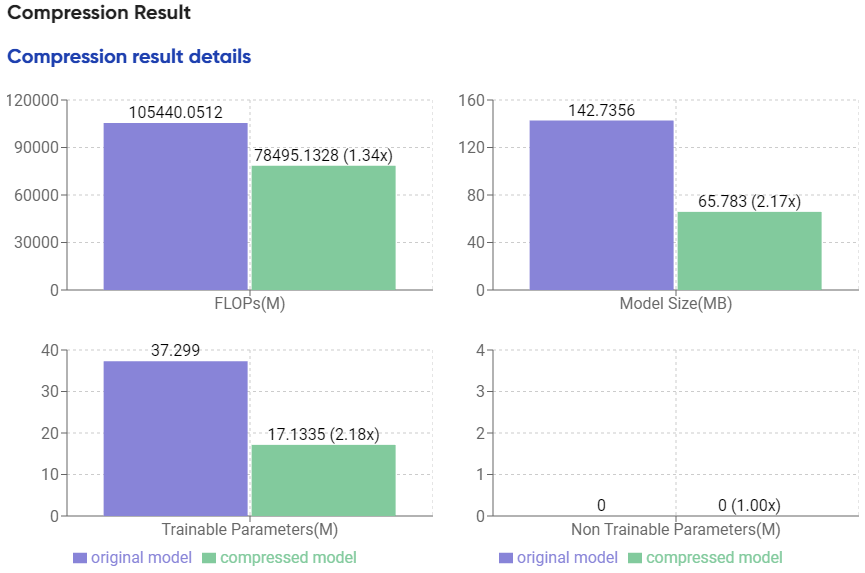
</div>
<div align='center'>
Fig 2. The compression result of Compressed-1.
</div>

<a name="2.-Fine-tuning-the-Compressed-Model"></a>
# 2. Fine-tuning the Compressed Model
Structure pruning or Decomposition may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
* For Compressed-1, `L2 Norm Pruning` &rarr; `Fine-tuning`.
* For Compressed-2, `L2 Norm Pruning` &rarr; `Fine-tuning` &rarr; `Tucker Decomposition` &rarr; `Fine-tuning`

<a name="#-Preparing PASCAL VOC dataset"></a>
### Preparing PASCAL VOC dataset

In [ ]:
# Download VOC dataset
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/scripts/voc.sh
! sh voc.sh

# Convert VOC as YOLO format
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/scripts/voc2yolo.py
! python voc2yolo.py

<a name='#-Preparing-YAML-files-for-fine-tuning-the-model-on-PASCAL-VOC'></a>
### Preparing YAML files for fine-tuning the model on PASCAL VOC

In [ ]:
# Downloading a PASCAL VOC yolov7 trainig model config file
! cd cfg/training && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/yolov7-voc.yaml

# Downloading a PASCAL VOC data config file
! cd data && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/voc.yaml

# Downloading a PASCAL VOC YOLOv7 training hyper-parameter config file
! cd data && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/hyp.scratch.p5-voc.yaml

<a name='#fine-tuning'></a>
### Fine-tuning the compressed model

To fine-tune the compressed model, we need to modify some codes in `train.py` and `test.py`. You can get the modified codes `train_npmc.py` and `test_npmc.py` by running the following code block. You can see the details of the modifications in [Appendix 1](#Appendix-1.-Transfer-Learning-on-PASCAL-VOC).

In [ ]:
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/train_npmc.py
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/test_npmc.py

As the model is converted into GraphModule format, the post process of the model is detached. To recover this, we define a new class for it. Mo

In [ ]:
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/yolo.py -O models/yolo.py

In this notebook, we fine-tune ([link](#2.-Fine-tuning-the-Compressed-Model)) and verify ([link](#3.-Compression-Results)) the model for the best practice case of Fig. 1 by default.  
* `yolov7_voc_compressed_model_L2Norm_03.pt` means the model compressed by `L2 Norm Pruning (pruning ratio: 0.3)`.

In [ ]:
# Please check the configs for fine-tuning and modify if you need.

from easydict import EasyDict as edict

configs = edict()
configs.workers = 8
configs.device = '0'
configs.batch_size = 4
configs.data = 'data/voc.yaml'
configs.cfg = 'cfg/training/yolov7-voc.yaml'
configs.weights = ''
configs.hyps = 'data/hyp.scratch.p5-voc.yaml'
configs.name = 'finetuned_yolov7_voc_compressed_model_L2Norm_03'
configs.graphmodule_model = 'yolov7_voc_compressed_model_L2Norm_03.pt'
configs.epochs = 300

In [ ]:
! python train_npmc.py \
--workers {configs.workers} \
--device {configs.device} \
--batch-size {configs.batch_size} \
--data {configs.data} \
--cfg {configs.cfg} \
--name {configs.name} \
--hyp {configs.hyps} \
--graphmodule-model {configs.graphmodule_model} \
--epochs {configs.epochs} \
--noautoanchor

### Reparameterization
YOLOv7 includes `RepConv` and `Implicit knowledge` layers of which structures are changed at inference time.

Reparameterizing original model

In [ ]:
configs.original_model = "yolov7_voc.pt"
configs.original_rep_model = "yolov7_voc_rep.pt"

In [ ]:
import torch
from models.yolo import Model

original_model = torch.load(configs.original_model)
original_rep_model = Model(configs.cfg,3,20)
original_rep_model.load_state_dict(original_model.state_dict(),strict=False)

with torch.no_grad():
    original_rep_model.fuse()

torch.save(original_rep_model, 'yolov7_voc_rep.pt')

To reparameterization GraphModule format YOLOv7, please download `reparameterization_npmc.py` and run the following code.
* `yolov7_voc_compressed_model_L2Norm_03_rep.pt` means a reparameterized model after fine-tuning the compressed model.

In [ ]:
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/reparameterization_npmc.py

Reparameterizing compressed model

In [ ]:
configs.compressed_rep_model = f"{configs.name}_rep.pt"
configs.finetuned_model_weight = f"runs/train/{configs.name}/weights/best.pt"

In [ ]:
! python reparameterization_npmc.py \
--model {configs.finetuned_model_weight} \
--save_model_path {configs.compressed_rep_model}

<a name="3.-Compression-Results"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on YOLOv7.

* [Visualizing the optimization process on YOLOv7](#Visualizing-the-optimization-process-on-YOLOv7)
* [Architecture of the compressed model](#Architecture-of-the-compressed-model)
* [Accuracy-comparison](#Accuracy-comparison)
* [FLOPs & Parameters comparison](#FLOPs-&-Parameters-comparison)
* [Latency-comparison](#Latency-comparison)

<a name='Visualizing-the-optimization-process-on-YOLOv7'></a>

### Visualizing the optimization process on YOLOv7

Fig.3 visualizes part of the original and pruned YOLOv7.
Here, we applied [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) (Compressed-1) and [Tucker Decomposition](https://docs.netspresso.ai/docs/mc-filter-decomposition#what-is-filter-decomposition) (Compressed-2) to optimize the model.
<div align="center">

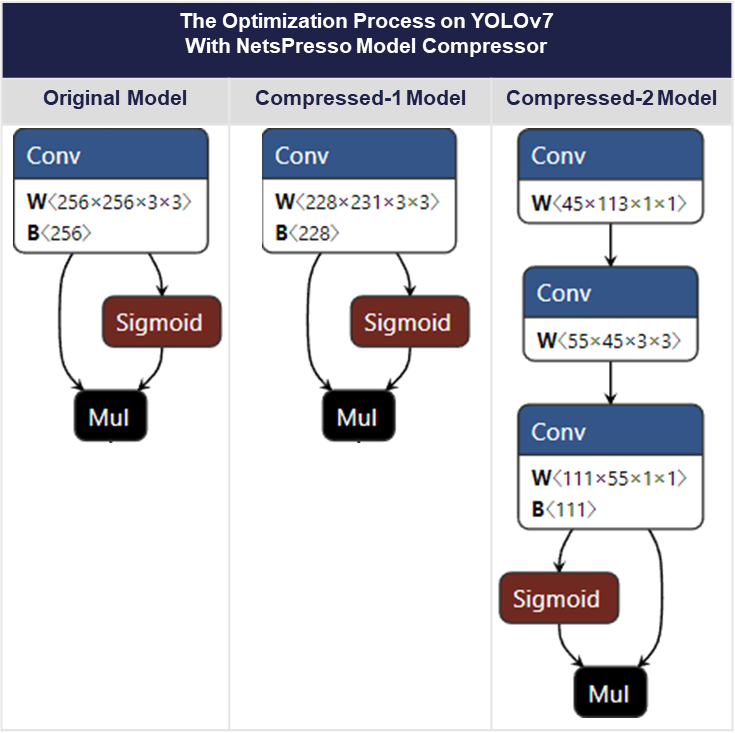
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in YOLOv7 with NetsPresso Model Compressor</div>

<a name="Architecture-of-the-compressed-model"></a>

### Architecture of the compressed model

In [ ]:
import torch
from torchsummary import summary

device = 'cpu'
compressed_model = torch.load(configs.compressed_rep_model).to(device)

summary(compressed_model.to(device),(3,640,640),device=device)

<a name="Accuracy-comparision"></a>
### Accuracy comparision

Evaluation code for the original model

In [ ]:
# Please check the configs for evaluation and modify if you need.

from easydict import EasyDict as edict

eval_configs = edict()
eval_configs.workers = 8
eval_configs.device = '0'
eval_configs.batch_size = 4
eval_configs.data = 'data/voc.yaml'
eval_configs.cfg = 'cfg/training/yolov7-voc.yaml'

eval_configs.compressed_rep_model = configs.compressed_rep_model

In [ ]:
! python test_npmc.py \
--data {eval_configs.data} \
--batch-size {eval_configs.batch_size} \
--conf 0.001 \
--iou 0.65 \
--device {eval_configs.device} \
--cfg {eval_configs.cfg} \
--graphmodule-model {eval_configs.original_model} \
--no-trace

In [ ]:
! python test_npmc.py \
--data {eval_configs.data} \
--batch-size {eval_configs.batch_size} \
--conf 0.001 \
--iou 0.65 \
--device {eval_configs.device} \
--cfg {eval_configs.cfg} \
--graphmodule-model {eval_configs.compressed_rep_model} \
--no-trace

<a name="FLOPs-&-Parameters-comparision"></a>
### FLOPs & Parameters comparision

In [ ]:
from thop import profile
from torchinfo import summary
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

original_model = torch.load(configs.original_rep_model, map_location='cpu').to(device)
compressed_model = compressed_model.to(device)

input_size = 640
dummy_input = torch.ones((1,3,input_size,input_size)).to(device)

original_macs, _ = profile(original_model, inputs=(dummy_input, ))
compressed_macs, _ = profile(compressed_model.eval(), inputs=(dummy_input, ))

original_params = summary(original_model, (1,3,input_size, input_size)).total_params
compressed_params = summary(compressed_model.eval(), (1,3,input_size, input_size)).total_params
print(original_macs, original_params)
print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

### Latency comparision

In [ ]:
import onnx
import torch
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,640,640)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

original_model = torch.load(configs.original_rep_model, map_location='cpu')
compressed_model = torch.load(configs.compressed_rep_model, map_location='cpu')

onnxExport(original_model, 'yolov7_voc_rep.onnx')
onnxExport(compressed_model, 'yolov7_voc_compressed_model_L2Norm_03_rep.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 640
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('yolov7_voc_rep.onnx',run_times=10)
compressed_latency = inference_time('yolov7_voc_compressed_model_L2Norm_03_rep.onnx',run_times=10)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

<a name="Appendix-1.-Transfer-Learning-on-PASCAL-VOC"></a>
# Appendix 1. Transfer Learning on PASCAL VOC
In this section, we provide the details of how to get PASCAL VOC pretrained YOLOv7.

### Transfer Learning

To do transfer learning the COCO pretrained YOLOv7 model on PASCAL VOC, we need YAML files for fine-tuning the model on PASCAL VOC.
- Please run this [code block](#-Preparing-YAML-files-for-fine-tuning-the-model-on-PASCAL-VOC) to prepare the YAML files.

Please prepare PASCAL VOC dataset. Run this [code block](#-Preparing-PASCAL-VOC-dataset) if you don't have the dataset.

Downloading COCO pretrained YOLOv7

In [ ]:
! wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

### Transfer Learning

In [ ]:
# Please check the configs for transfer learning and modify if you need.

from easydict import EasyDict as edict

tl_configs = edict()
tl_configs.workers = 8
tl_configs.device = '0'
tl_configs.batch_size = 16
tl_configs.data = 'data/voc.yaml'
tl_configs.cfg = 'cfg/training/yolov7-voc.yaml'
tl_configs.weights = 'yolov7_training.pt'
tl_configs.hyps = 'data/hyp.scratch.p5-voc.yaml'
tl_configs.name = 'yolov7_voc'
tl_configs.epochs = 300

In [ ]:
! python train.py \
--workers {tl_configs.workers} \
--device {tl_configs.device} \
--batch-size {tl_configs.batch_size} \
--data {tl_configs.data} \
--cfg {tl_configs.cfg} \
--weights {tl_configs.weights} \
--name {tl_configs.name} \
--hyp {tl_configs.hyps} \
--epochs {tl_configs.epochs}


### Conversion into GraphModule format

To convert the YOLOv7 into GraphModule format, we need to fix the flow of the model because `torch.fx` doen't support dynamic control flow now ([link](https://pytorch.org/docs/stable/fx.html#limitations-of-symbolic-tracing)). You can download the flow-fixed model (ModelForNPMC) by running the following code block.

In [ ]:
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/yolov7/best_practices/object_detection/torch/yolov7_voc/yolo.py -O models/yolo.py

Conversion into GraphModule format

You may need to fix the path to your model. Here, we set the default as `/runs/train/yolov7_voc/weights/best.pt`.

In [ ]:
from models.experimental import attempt_load
from utils.torch_utils import intersect_dicts
from models.yolo import ModelForNPMC
import torch
device = 'cpu'

trained_model = torch.load(f"runs/train/{tl_configs.name}/weights/best.pt")['model'].float().train() # modify the path to your model

model = ModelForNPMC(tl_configs.cfg,3 ,20)
model.load_state_dict(trained_model.state_dict())

graph = torch.fx.Tracer().trace(model)
traced_model = torch.fx.GraphModule(model, graph)
    
torch.save(traced_model, f"{tl_configs.name}.pt")

<a name="Appendix-2.-Description-of-The-Modifications"></a>
# Appendix 2. Description of The Modifications
In this section, we go into detail about the code we've changed for the compression.

### For exporting

* `yolo.py`
  * The Flow of YOLOv7 needs to be fixed to convert the model into GraphModule format. Here, we delete two conditional statements ([augment](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/d15a75a169f9a47c03fd0f0c4cd9457b37fe6b9b#diff-7514ec60cefb31713f12cbd5c436fe301315031af8ff4f5457a851671c375256L889), [profile](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/d15a75a169f9a47c03fd0f0c4cd9457b37fe6b9b#diff-7514ec60cefb31713f12cbd5c436fe301315031af8ff4f5457a851671c375256L921)) in `Model` and name the class `ModelForNPMC`. We followed the default settings (`augment`: False, `profile`: False).
  * We convert the model to training mode to fine-tune it after compression. Therefore, flow only for inference ([link](https://github.com/WongKinYiu/yolov7/blob/main/models/yolo.py#L129)) is omitted after converting the model. We define a new class `DetectPostPart` to attach the omitted flow. ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/d9f5163624b93a556e47013715c9b22c01173246)) It is used in `train_npmc.py` ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/587c599daf1d40d4e1b394dbe5ff5fb1110ae712#diff-29c9590143534c12958975d0bce0b5468b63e0c484458449f3c8098b5c03ce00R97)) and `test_npmc.py` ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/57df7acde181077f4c9fd86c893190d2b177fb2d#diff-379f43d60815667a6e8aeb14a85001d393c44f8c10ede96eb2e9f7ca8ed17369R73)) for inference.


### For Training

* `train_npmc.py`
  * The names of a model's attributes are likely to be changed after compressing the model. Here, we modify the way to access the compressed model parameters. ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/ed6c724be14b4c5af1a4229d1b5ed1153cdbd471#diff-29c9590143534c12958975d0bce0b5468b63e0c484458449f3c8098b5c03ce00R130))
  * A model loses some attributes when it is converted into GraphModule format. We get those attributes from the original model and assign them to the compressed model. ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/ed6c724be14b4c5af1a4229d1b5ed1153cdbd471#diff-29c9590143534c12958975d0bce0b5468b63e0c484458449f3c8098b5c03ce00L83))
  * We add a new argument `--graphmodule-model` in argparser to get the compressed model path. ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/ed6c724be14b4c5af1a4229d1b5ed1153cdbd471#diff-29c9590143534c12958975d0bce0b5468b63e0c484458449f3c8098b5c03ce00R557))

* `test_npmc.py`
  * Like `train_npmc.py`, we assign the attributes of the original model to the compressed model. ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/be6237ca9c28b68df8a16f687e171976921dd930#diff-379f43d60815667a6e8aeb14a85001d393c44f8c10ede96eb2e9f7ca8ed17369R59))
  * We add a new argument `detect_post_part` in the function `test` to get the instance of `DetectPostPart` for attaching inference flow. ([function definition](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/be6237ca9c28b68df8a16f687e171976921dd930#diff-379f43d60815667a6e8aeb14a85001d393c44f8c10ede96eb2e9f7ca8ed17369R44), [use in train_npmc.py](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/7cde5d0dc388df0d8fc26553df4be2960863d1f3#diff-29c9590143534c12958975d0bce0b5468b63e0c484458449f3c8098b5c03ce00R419), [use in test_npmc.py](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/be6237ca9c28b68df8a16f687e171976921dd930#diff-379f43d60815667a6e8aeb14a85001d393c44f8c10ede96eb2e9f7ca8ed17369R132))
  * We add arguments `--graphmodule-model` and `--cfg` in argparser to get the compressed model and the original model (for lost attributes) respectively. ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/be6237ca9c28b68df8a16f687e171976921dd930#diff-379f43d60815667a6e8aeb14a85001d393c44f8c10ede96eb2e9f7ca8ed17369R330))

### For Reparameterization
* `reparameterization_npmc.py`
  * A reparameterization process is required to merge BN layers to Conv layers and to combine implicit knowledge with convolution feature map. We define a new function `reparameterization_npmc.py` to reparameterize the GraphModule model ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/3df47e6780c3613d0c1a2590f20dc8dd2f1aa630)). You can check the original codes for fusing BN and conv layers from [here](https://github.com/pytorch/pytorch/blob/40cbf342d3c000712da92cfafeaca651b3e0bd3e/torch/fx/experimental/optimization.py#L50). Note that `reparameterization_npmc.py` is created only for yolov7. Layer names should be changed if you want to reparameterize your custom model.
